# Email category prediction

In [1]:
# import supporting functions from python file
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

import seaborn as sns
import pandas as pd
import numpy as np

import supporting_modules.supp_functions as sfn
import string

In [2]:
# import dataset

from sklearn.datasets import fetch_20newsgroups

## Fetch the training data and the test ones

In [3]:
train_data = fetch_20newsgroups(subset="train")
test_data = fetch_20newsgroups(subset="test")

### Checking the size of each category

In [4]:
# let's look what categories we have in dataset and how many are they

f"{train_data.target_names}", "_" * 30, f"Number of categories: {len(train_data.target_names)}"

("['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']",
 '______________________________',
 'Number of categories: 20')

/home/konrad/Dokumenty/python/github_projects/sages_project/sentiment_analysis_on_movie_reviews/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/konrad/Dokumenty/python/github_projects/sages_project/sentiment_analysis_on_movie_reviews/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/konrad/Dokumenty/python/github_projects/sages_project/sentiment_analysis_on_movie_reviews/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.i

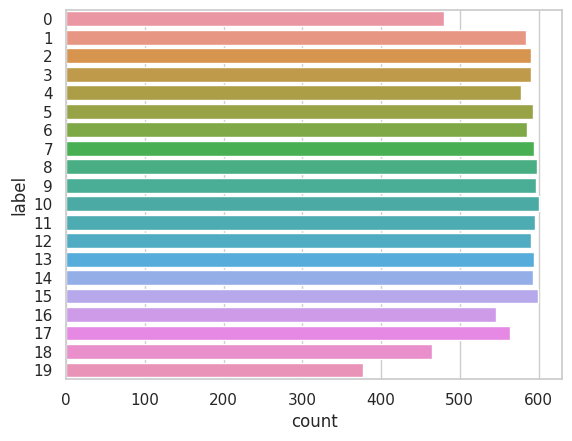

In [5]:
# show the countplot to see the differences between number of emails for each category

labels = pd.DataFrame(train_data.target, columns=["label"])
sns.set_theme(style="whitegrid")

sns.countplot(data = labels, y = "label");

In [6]:
# the differences between the categories 
# comparison diffs between the most numerous and the least numerous grpup

cnt_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 
            10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0}

for x in train_data.target:
    cnt_dict[x] += 1
as_list = list(cnt_dict.values())

print("count of each category:", cnt_dict)
print("--"*50)
print("smallest categories count: ", sorted(as_list)[:4])
print("highest categories: ", sorted(as_list)[-4:])
print(np.median(as_list))

count of each category: {0: 480, 1: 584, 2: 591, 3: 590, 4: 578, 5: 593, 6: 585, 7: 594, 8: 598, 9: 597, 10: 600, 11: 595, 12: 591, 13: 594, 14: 593, 15: 599, 16: 546, 17: 564, 18: 465, 19: 377}
----------------------------------------------------------------------------------------------------
smallest categories count:  [377, 465, 480, 546]
highest categories:  [597, 598, 599, 600]
591.0


In [7]:
# lets look how many emails in both datasets are (train, test)
# the porportions are like ~60% train / ~40% test

len(train_data.data), len(test_data.data), \
len(test_data.data) / (len(train_data.data) + len(test_data.data))

(11314, 7532, 0.3996604053910644)

## step 1: Text data cleanup

Let's look at what the example data looks like. As it is visible there are a lot of elements that would cause the noise if they wouldn't be erased. 

In [8]:
# lets look how the emails looks like
import random

# randomly pick an example of an email and show it: 

email_no = random.randint(0, 11314)
print(email_no)
print(train_data.data[email_no])
new_txt = train_data.data[email_no]

2548
From: walkup@cs.washington.edu (Elizabeth Walkup)
Subject: Re: Menangitis question
Organization: Computer Science & Engineering, U. of Washington, Seattle
Distribution: na
Lines: 19

In article <19439@pitt.UUCP> geb@cs.pitt.edu (Gordon Banks) writes:
>... the neiseria meningococcus is one of the most common
>forms of meningitis.  It's the one that sometimes sweeps
>schools or boot camp.  It is contagious and kills by attacking
>the covering of the brain, causing the blood vessels to thrombose
>and the brain to swell up.
>
>	...
>
>It can live in the throat of carriers.  Don't worry, you won't get 
>it from them, especially if they took the medication.

Assuming one has been cultured as having a throat laden with
neiseria meningococcus and given (and taken) a course of ERYC 
without the culture becoming negative, should one worry about
being a carrier?  

-- Elizabeth
   walkup@cs.washington.edu



## Remove header info

There are some constant values that repeat in a huge number of message content. They are header elements like "from: ....", "subject: ..." etc. They also have no informative value and should be rejected. It can be conducted for example like that: 

In [11]:
email_text = new_txt

# remove most common header components

def is_header_tag_in(tags: tuple, txt: str): 
    # check if header tag is in sentence or not
    for tag in tags:
        if tag in txt.lower():
            return True
    return False

header_tags = ("from:", "subject:", "lines:", "organization:", "distribution", \
               "nntp-posting-host:", "reply-to:", "keywords:", "summary:", "re:", "expires:", 
                  "article-i.d.:", "newsreader:")

# clear all rows that start with word from header_tags tuple
email_text = " ".join([x for x in email_text.split("\n") \
                       if not is_header_tag_in(header_tags, x)]).\
                strip()

In [12]:
email_text

"In article <19439@pitt.UUCP> geb@cs.pitt.edu (Gordon Banks) writes: >... the neiseria meningococcus is one of the most common >forms of meningitis.  It's the one that sometimes sweeps >schools or boot camp.  It is contagious and kills by attacking >the covering of the brain, causing the blood vessels to thrombose >and the brain to swell up. > >\t... > >It can live in the throat of carriers.  Don't worry, you won't get  >it from them, especially if they took the medication.  Assuming one has been cultured as having a throat laden with neiseria meningococcus and given (and taken) a course of ERYC  without the culture becoming negative, should one worry about being a carrier?    -- Elizabeth    walkup@cs.washington.edu"

## Email addresses inside the email content

Such "words" contain no informative value so they can be removed. Some addresses can repeat in a few or more emails and then the model could treat them as useful information which of course it isn't. 

In [13]:
import re
# [re.sub("<.*?>", "", article) for article in articles]

def clear_emails(txt: str):
    return re.sub(r"\S*@\S*\s?", "", txt)
    
cleaner_txt = clear_emails(new_txt).lower()
cleaner_txt

"from: (elizabeth walkup)\nsubject: re: menangitis question\norganization: computer science & engineering, u. of washington, seattle\ndistribution: na\nlines: 19\n\nin article (gordon banks) writes:\n>... the neiseria meningococcus is one of the most common\n>forms of meningitis.  it's the one that sometimes sweeps\n>schools or boot camp.  it is contagious and kills by attacking\n>the covering of the brain, causing the blood vessels to thrombose\n>and the brain to swell up.\n>\n>\t...\n>\n>it can live in the throat of carriers.  don't worry, you won't get \n>it from them, especially if they took the medication.\n\nassuming one has been cultured as having a throat laden with\nneiseria meningococcus and given (and taken) a course of eryc \nwithout the culture becoming negative, should one worry about\nbeing a carrier?  \n\n-- elizabeth\n   "

In [14]:
# remove digits

def clear_txt_with_digits(txt: str): 
    return re.sub(r"\S*[0-9]+\S*\s?", "", txt)

cleaner_txt = clear_txt_with_digits(cleaner_txt)
cleaner_txt

"from: (elizabeth walkup)\nsubject: re: menangitis question\norganization: computer science & engineering, u. of washington, seattle\ndistribution: na\nlines: \nin article (gordon banks) writes:\n>... the neiseria meningococcus is one of the most common\n>forms of meningitis.  it's the one that sometimes sweeps\n>schools or boot camp.  it is contagious and kills by attacking\n>the covering of the brain, causing the blood vessels to thrombose\n>and the brain to swell up.\n>\n>\t...\n>\n>it can live in the throat of carriers.  don't worry, you won't get \n>it from them, especially if they took the medication.\n\nassuming one has been cultured as having a throat laden with\nneiseria meningococcus and given (and taken) a course of eryc \nwithout the culture becoming negative, should one worry about\nbeing a carrier?  \n\n-- elizabeth\n   "

## Add these substeps to the function

In [15]:
# remove most common header components

def is_header_tag_in(tags: tuple, txt: str): 
    # check if header tag is in sentence or not
    for tag in tags:
        if tag in txt.lower():
            return True
    return False

def clear_emails(txt: str):
    return re.sub(r"\S*@\S*\s?", "", txt)

# create dict where keys are symbols from '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
# with None as vlues
table = str.maketrans({key: None for key in string.punctuation})

def clean_email_content(email_text: str, table: dict = table): 
    
    header_tags = ("from:", "subject:", "lines:", "organization:", "distribution", \
               "nntp-posting-host:", "reply-to:", "keywords:", "summary:", "re:", "expires:", 
                  "article-i.d.:", "newsreader:")
    
    # clear all rows that start with word from header_tags tuple
    email_text = " ".join([x for x in email_text.split("\n") \
                           if not is_header_tag_in(header_tags, x)]).\
                    strip()
    
    # remove e-mail addresses from content
    # then change all character to lower case
    email_text = clear_emails(email_text).lower()
    
    # clear words with digits inside
    email_text = clear_txt_with_digits(email_text)
    
    # clean whiespaces except space
    email_text = re.sub(r'[^\S ]+', '', email_text)   
    
    # email_text = email_text.translate(table)
    
    return email_text

In [16]:
clean_email_content(cleaner_txt)

"in article (gordon banks) writes: >... the neiseria meningococcus is one of the most common >forms of meningitis.  it's the one that sometimes sweeps >schools or boot camp.  it is contagious and kills by attacking >the covering of the brain, causing the blood vessels to thrombose >and the brain to swell up. > >... > >it can live in the throat of carriers.  don't worry, you won't get  >it from them, especially if they took the medication.  assuming one has been cultured as having a throat laden with neiseria meningococcus and given (and taken) a course of eryc  without the culture becoming negative, should one worry about being a carrier?    -- elizabeth"